# Trees

In [377]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [378]:
df = pd.read_csv('CreditScoring.csv')

In [379]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Data Cleaning

In [380]:
def standardise_colnames(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  return df

In [381]:
df = standardise_colnames(df)

In [382]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [383]:
status_values = {
  0: 'unk',
  1: 'ok',
  2: 'default'
}
df.status = df.status.map(status_values)

In [384]:
home_values = {
  0: 'unk',
  1: 'rent',
  2: 'owner',
  3: 'private',
  4: 'ignore',
  5: 'parents',
  6: 'other'
}
df.home = df.home.map(home_values)

In [385]:
marital_values = {
  0: 'unk',
  1: 'single',
  2: 'married',
  3: 'widow',
  4: 'separated',
  5: 'divorced'
}
df.marital = df.marital.map(marital_values)

In [386]:
records_values = {
  0: 'unk',
  1: 'no',
  2: 'yes'
}
df.records = df.records.map(records_values)

In [387]:
job_values = {
  0: 'unk',
  1: 'fixed',
  2: 'partime',
  3: 'freelance',
  4: 'others'
}
df.job = df.job.map(job_values)

In [388]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [389]:
df.income = df.income.replace(df.income.max(), np.nan)
df.assets = df.assets.replace(df.assets.max(), np.nan)
df.debt = df.debt.replace(df.debt.max(), np.nan)

In [390]:
df = df.loc[df.status != 'unk'].reset_index(drop=True)

## Validation Framework

In [391]:
df_train_full, df_test = train_test_split(df, test_size=.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=.25, random_state=11)

In [392]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [393]:
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

In [394]:
df_train.drop('status', axis=1, inplace=True, errors='ignore')
df_val.drop('status', axis=1, inplace=True, errors='ignore')
df_test.drop('status', axis=1, inplace=True, errors='ignore')

In [395]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


## Feature Preparation

In [396]:
def encode_vars(df: pd.DataFrame, dv: DictVectorizer = None):
  df_dicts = df.fillna(0).to_dict(orient='records')

  if not dv:
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dicts)
  
  encoded_data = dv.transform(df_dicts)

  return encoded_data, dv

In [397]:
X_train, dv = encode_vars(df_train)
X_val, _ = encode_vars(df_val, dv)
X_test, _ = encode_vars(df_test, dv)

In [398]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2672, 29)
(891, 29)
(891, 29)


## Decision Trees
A decision tree is a data structure with a root node with branches leading to child nodes. Each node represents a binary decision point in the model where incoming data points are classified and passed along the corresponding branch.

In [399]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [400]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [401]:
roc_auc_score(y_val, y_pred)

0.6622659901673488

In [402]:
y_pred = dt.predict_proba(X_train)[:, 1]

In [403]:
roc_auc_score(y_train, y_pred)

1.0

The decision tree is overfitted because it has unrestricted depth, and can create infinite classification rules.

In [404]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [405]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7389079944782155

In [406]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.7761016984958594

We achieve better validation performance by restricting the tree depth.

In [407]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## Decision Tree Learning Algorithm
- Every node has a condition that takes the form of a feature and a threshold value.
- Datapoints are split based on this threshold value.
- Optimal splitting thresholds are identified by evaluating the missclassification rate for different threshold values
- find the lowest impurity split across features to find the next feature to add to the tree
- stopping criteria: pure group (0% impurity), max depth, min group size

## Parameter Tuning
max_depth, min_samples_leaf

In [408]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
  dt = DecisionTreeClassifier(max_depth=d)
  dt.fit(X_train, y_train)

  y_pred = dt.predict_proba(X_val)[:, 1]
  auc = roc_auc_score(y_val, y_pred)

  print(f'Depth: {d} -> {auc:.3f}')

Depth: 1 -> 0.606
Depth: 2 -> 0.669
Depth: 3 -> 0.739
Depth: 4 -> 0.761
Depth: 5 -> 0.767
Depth: 6 -> 0.757
Depth: 10 -> 0.704
Depth: 15 -> 0.664
Depth: 20 -> 0.660
Depth: None -> 0.654


In [409]:
scores = []

for d in [4, 5, 6, 10, 15, 20, None]:
  for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
    dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((d, s, auc))
    # print(f'(Depth: {d}, Min Samples Leaf: {s}) -> {auc:.3f}')

In [410]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [411]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])

In [412]:
df_scores_pivot.round(3)

auc                                          
max_depth           NaN   4.0    5.0    6.0    10.0   15.0   20.0
min_samples_leaf                                                 
1                 0.653  0.761  0.767  0.759  0.683  0.655  0.654
2                 0.679  0.761  0.766  0.763  0.711  0.679  0.685
5                 0.710  0.761  0.768  0.760  0.731  0.722  0.713
10                0.765  0.761  0.762  0.778  0.766  0.760  0.756
15                0.788  0.764  0.773  0.785  0.791  0.787  0.787
20                0.782  0.761  0.774  0.774  0.785  0.781  0.782
100               0.780  0.756  0.763  0.776  0.780  0.779  0.779
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

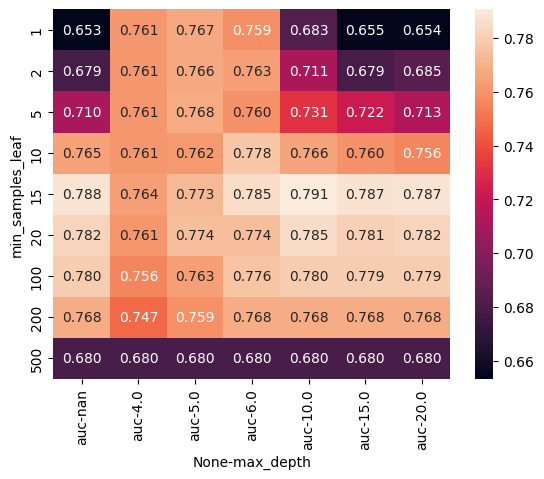

In [413]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [414]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## Random Forest
- Suppose we have multiple classification models g_i that give independent predictions given some input data
- The predicitons are aggregated by averaging the individual prediction probabilities
- When the base models are decision trees, then the we a random forest
- The forest is called random because each model receives a different set of features to base predictions on

In [415]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [416]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [417]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

## Random Forest Parameter Tuning
n_estimators, max_depth, min_samples_leaf

In [418]:
scores = []
for n in range(10, 201, 10):
  rf = RandomForestClassifier(n_estimators=n, random_state=1)
  rf.fit(X_train, y_train)

  y_pred = rf.predict_proba(X_val)[:, 1]

  auc = roc_auc_score(y_val, y_pred)
  scores.append((n, auc))

In [419]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

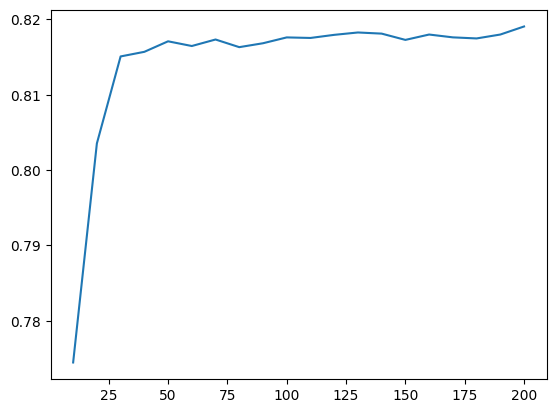

In [420]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.show()

In [421]:
n = 100

In [422]:
scores = []
for d in [5, 10, 15]:
  for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append((d, n, auc))

In [423]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

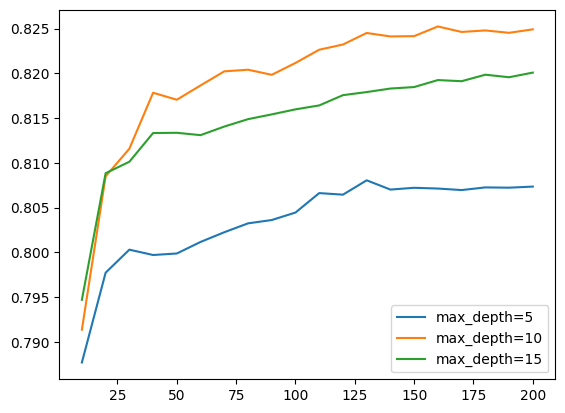

In [424]:
for d in [5, 10, 15]:
  df_subset = df_scores[df_scores.max_depth == d]
  plt.plot(df_subset.n_estimators, df_subset.auc, label=f'max_depth={d}')
plt.legend()
plt.show()

In [425]:
max_depth = 10

In [426]:
scores = []
for s in [1, 3, 5, 10, 50]:
  for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s,  random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append((s, n, auc))

In [427]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])

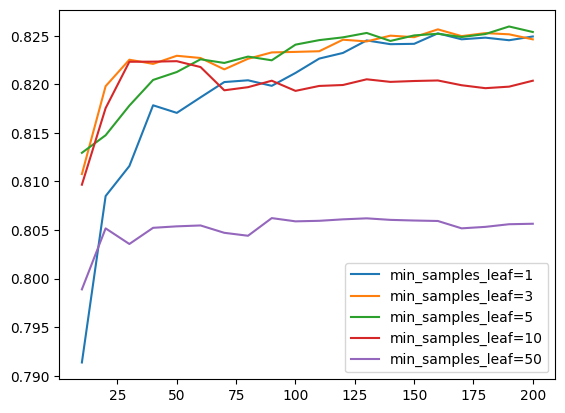

In [428]:
for s in [1, 3, 5, 10, 50]:
  df_subset = df_scores[df_scores.min_samples_leaf == s]
  plt.plot(df_subset.n_estimators, df_subset.auc, label=f'min_samples_leaf={s}')
plt.legend()
plt.show()

In [429]:
min_samples_leaf = 3

In [430]:
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=min_samples_leaf,  random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Other random forest params:
- bootstrap: selecting a subset of rows (datapoints) to feed each base model
- max_features: the maximum number of features to feed each base model
- n_jobs: parallelization of model training (-1 uses all available processors)

## Gradient Boosting and XGBoost
With a random forest, models are trained independently and their output is then combined to form the final model outout.

Gradient boosting train models sequentially:
- an initial model is trained on a dataset and makes predictions
- the next model takes the previous model's errors as input for training
- each subsequent model corrects the mistakes of the previous one

When each model in the sequence is a decision tree, we get a Gradient Boosting Tree

In [431]:
d_train = xgb.DMatrix(X_train, label=y_train, feature_names=list(dv.get_feature_names_out()))
d_val = xgb.DMatrix(X_val, label=y_val, feature_names=list(dv.get_feature_names_out()))
d_test = xgb.DMatrix(X_test, label=y_test, feature_names=list(dv.get_feature_names_out()))

In [432]:
xgb_params = {
  'eta': .3,
  'max_depth': 6,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

In [433]:
model = xgb.train(xgb_params, d_train, num_boost_round=200)

In [434]:
y_pred = model.predict(d_val)
roc_auc_score(y_val, y_pred)

0.8072491584122448

In [435]:
watchlist = [(d_train, 'train'), (d_val, 'val')]

xgb_params = {
  'eta': .3,
  'max_depth': 6,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'eval_metrics': 'auc',
  'nthread': 8,
  'seed': 1,
  'verbosity': 1
}

model = xgb.train(xgb_params, d_train, num_boost_round=200, evals=watchlist)

[0]	train-logloss:0.49703	val-logloss:0.54305


[1]	train-logloss:0.44463	val-logloss:0.51462
[2]	train-logloss:0.40707	val-logloss:0.49896
[3]	train-logloss:0.37760	val-logloss:0.48654
[4]	train-logloss:0.35990	val-logloss:0.48007
[5]	train-logloss:0.33931	val-logloss:0.47563
[6]	train-logloss:0.32586	val-logloss:0.47413
[7]	train-logloss:0.31409	val-logloss:0.47702
[8]	train-logloss:0.29962	val-logloss:0.48205
[9]	train-logloss:0.29216	val-logloss:0.47996
[10]	train-logloss:0.28407	val-logloss:0.47969
[11]	train-logloss:0.27583	val-logloss:0.47888
[12]	train-logloss:0.27127	val-logloss:0.47697
[13]	train-logloss:0.26525	val-logloss:0.47871
[14]	train-logloss:0.25734	val-logloss:0.48096
[15]	train-logloss:0.25186	val-logloss:0.48160


/Users/bastienwinant/Desktop/Projects/ml-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:08:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	train-logloss:0.24849	val-logloss:0.47982
[17]	train-logloss:0.24144	val-logloss:0.48086
[18]	train-logloss:0.23796	val-logloss:0.47978
[19]	train-logloss:0.23390	val-logloss:0.47857
[20]	train-logloss:0.22833	val-logloss:0.48036
[21]	train-logloss:0.22539	val-logloss:0.48004
[22]	train-logloss:0.22170	val-logloss:0.48314
[23]	train-logloss:0.21782	val-logloss:0.48435
[24]	train-logloss:0.21589	val-logloss:0.48557
[25]	train-logloss:0.21079	val-logloss:0.48589
[26]	train-logloss:0.20503	val-logloss:0.48517
[27]	train-logloss:0.20055	val-logloss:0.48980
[28]	train-logloss:0.19486	val-logloss:0.48914
[29]	train-logloss:0.19126	val-logloss:0.49257
[30]	train-logloss:0.19005	val-logloss:0.49460
[31]	train-logloss:0.18832	val-logloss:0.49629
[32]	train-logloss:0.18227	val-logloss:0.49812
[33]	train-logloss:0.17783	val-logloss:0.50094
[34]	train-logloss:0.17507	val-logloss:0.50277
[35]	train-logloss:0.17248	val-logloss:0.50598
[36]	train-logloss:0.17137	val-logloss:0.50709
[37]	train-lo

In [436]:
def parse_xgb_output():
  return